In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import scipy
from IPython.core.debugger import set_trace

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm
tqdm.pandas()

import gcsfs
gcp_fs = gcsfs.GCSFileSystem(project='data-science-pro-1dedbf8f')

/Users/joan-zoe/Envs/ml-lib/lib/python3.7/site-packages/tqdm/std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
/Users/joan-zoe/Envs/ml-lib/lib/python3.7/site-packages/google/auth/_default.py:66: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [2]:
with gcp_fs.open("covid-internal-data/postcodes/lsoa11cd_long_lat_lookup.csv") as data_file:
    df_uk_lsoa = pd.read_csv(data_file, low_memory=True, parse_dates=True).drop(columns=['geometry'])

In [3]:
day = 20200329
with gcp_fs.open("covid-kcl-anon-data/patients_export_"+str(day)+"_no_postcodes.csv") as data_file:
    df_pat = pd.read_csv(data_file, low_memory=True, parse_dates=True)

/Users/joan-zoe/Envs/ml-lib/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,50,51,53,55,56,57,58,59,60,61,62,63) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [105]:
with open('Population_estimates.csv') as f:
    population = pd.read_csv(f, header=1)
population = population.rename(columns={'All ages': 'population'})
population['population'] = population['population'].str.replace(',','').astype(int)

In [5]:
with gcp_fs.open("covid-kcl-anon-data/patients_export_"+str(day)+"_Geocodes.csv") as data_file:
    df_geocodes = pd.read_csv(data_file, low_memory=True, parse_dates=True).drop(columns='Unnamed: 0')

/Users/joan-zoe/Envs/ml-lib/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (2,3,4,5,6,7,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
with gcp_fs.open("covid-internal-data/aggregared_symptoms_without_postcode_"+str(day)+".csv") as data_file:
    df_agg = pd.read_csv(data_file, low_memory=True, parse_dates=True)

In [7]:
df_pat_with_lsoa = df_pat.merge(df_geocodes, on='id', how='left')

In [8]:
geo_df_pat_with_lsoa = df_pat_with_lsoa.merge(df_uk_lsoa, on='lsoa11cd', how='left')

In [9]:
df_agg = df_agg.drop(columns=['Unnamed: 0','Unnamed: 0.1', 'index'])

In [11]:
dfg = df_agg.merge(geo_df_pat_with_lsoa[['id','lsoa11cd','latitude','longitude',
                                          'already_had_covid','classic_symptoms']], 
                    left_on='patient_id', right_on='id',how='left')

In [13]:
dfg['already_had_covid'] = dfg['already_had_covid'].replace({'f':False,'t':True})
dfg['classic_symptoms'] = dfg['classic_symptoms'].replace({'f':False,'t':True})

In [14]:
dfg = gpd.GeoDataFrame(dfg, geometry=gpd.points_from_xy(dfg.longitude, dfg.latitude))

In [174]:
areas = gpd.read_file('Counties_and_Unitary_Authorities_December_2019_Boundaries_UK_BGC.geojson')

In [175]:
dfg_with_areas = gpd.sjoin(dfg, areas, op='within')

/Users/joan-zoe/Envs/ml-lib/lib/python3.7/site-packages/geopandas/tools/sjoin.py:61: UserWarning: CRS of frames being joined does not match!(None != epsg:4326)
  "(%s != %s)" % (left_df.crs, right_df.crs)


In [176]:
tmp = pd.read_csv('tested_covid.csv')

In [177]:
dfg_with_areas = dfg_with_areas.drop(columns=['tested_covid_positive'])

In [178]:
dfg_with_areas = dfg_with_areas.merge(tmp, on='patient_id', how='left')

In [179]:
def agg_vals(df):
    fatigue = sum(df.fatigue==True)
    loss_of_smell = sum(df.loss_of_smell==True)
    fever = sum(df.fever==True)
    diarrhoea= sum(df.diarrhoea==True)
    persistent_cough = sum(df.persistent_cough==True)
    any_symptom = sum(df[['fatigue','loss_of_smell', 'fever', 'diarrhoea', 'persistent_cough']].any(axis=1)==True)
    complex_symptom = sum(pd.concat([df[['fatigue', 'persistent_cough']].any(axis=1),
                                     df[['fever', 'diarrhoea', 'loss_of_smell']].any(axis=1)], axis=1).all(axis=1))
    
    tested = sum(df.had_covid_test==True)
    tested_positive = sum(df.tested_covid_positive==True)
    tested_negative = sum(df.tested_covid_positive==False)
    
    N = len(df)

    return pd.Series({'participants': len(df),
                     'loss_of_smell': loss_of_smell,
                     'fever': fever,
                     'diarrhoea':diarrhoea,
                     'fatigue': fatigue,
                     'persistent_cough': persistent_cough,
                     'tested':tested,
                     'tested_positive': tested_positive,
                     'tested_negative':tested_negative,
                     'complex_symptom': complex_symptom,
                     'any_symptom': any_symptom, 
                     'per_diarrhoea': diarrhoea/N*100,
                     'per_tested': tested/N*100,
                     'per_tested_positive': tested_positive/tested*100 if (tested !=0)  else np.nan,
                     'per_tested_negative':tested_negative/tested*100 if (tested !=0) else np.nan,
                     'per_any_symptom': any_symptom/N*100,
                     'per_fatigue': fatigue/N*100,
                     'per_loss_of_smell': loss_of_smell/N*100,
                     'per_fever':fever/N*100,
                     'per_persistent_cough':persistent_cough/N*100,
                     'per_complex_symptom': complex_symptom/N*100})

areas = areas.merge(dfg_with_areas.groupby('objectid').apply(agg_vals),
                    left_on='objectid',
                    right_on='objectid')

In [180]:
areas = areas.merge(population[['Code','Geography1','population']], left_on='ctyua19cd' , right_on='Code')

In [181]:
areas['penetration_rate'] = areas['participants']/areas['population']*100

/Users/joan-zoe/Envs/ml-lib/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


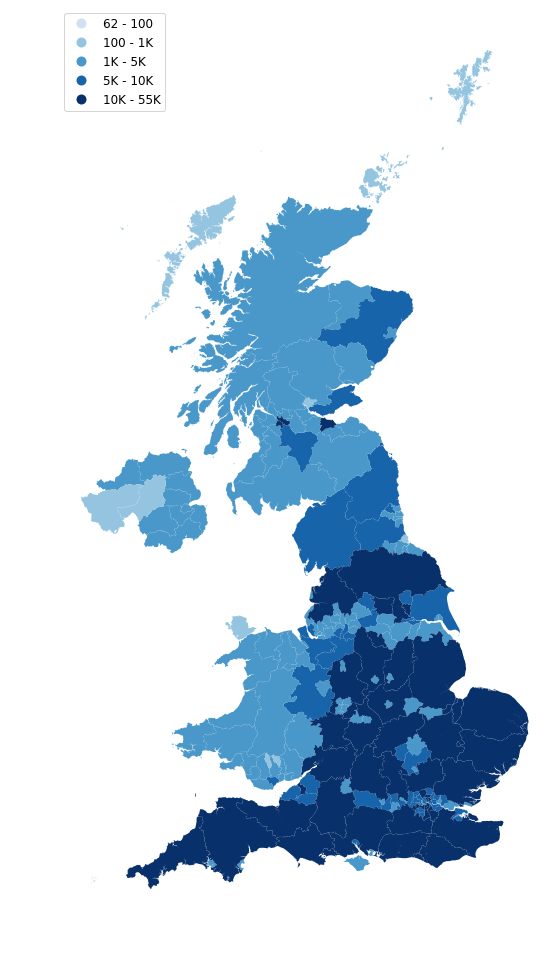

In [115]:
# co-ordinate transformations
target_crs = {'datum':'WGS84', 'no_defs':True, 'proj':'aea', 'lat_1':35, 'lat_2':55, 'lat_0':45, 'lon_0':10}  # UK specific


# plot stuff
fig, ax = plt.subplots(figsize=(10,17))
areas.to_crs(crs=target_crs, inplace=True)
f = areas.plot(ax=ax,
           column='participants',
           cmap='Blues',
           vmin=-1,
           scheme='UserDefined',
           classification_kwds={'bins': [ 100, 1000, 5000, 10000],},
           legend=True,
           legend_kwds={'title_fontsize':13,'fontsize':12, 'loc': 'upper left'})

# pretify
leg = f.get_legend()
labels = ['62 - 100','100 - 1K','1K - 5K','5K - 10K','10K - 55K']
for l,t in zip(labels,leg.get_texts()):
    t.set_text(l)
    
ax.axis('off')
fig.show()
plt.savefig('methods_paper/1_participants_'+str(day)+'.png')

/Users/joan-zoe/Envs/ml-lib/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


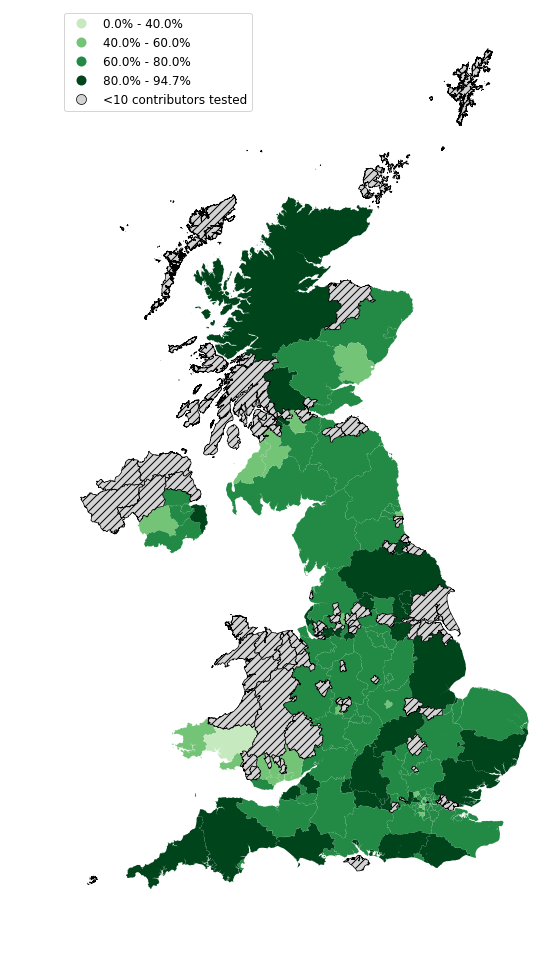

In [134]:
areas.loc[(areas.per_tested_negative>100) | (areas['tested']<=10),'per_tested_negative'] = np.nan

# co-ordinate transformations
target_crs = {'datum':'WGS84', 'no_defs':True, 'proj':'aea', 'lat_1':35, 'lat_2':55, 'lat_0':45, 'lon_0':10}  # UK specific


# plot stuff
fig, ax = plt.subplots(figsize=(10,17))
areas.to_crs(crs=target_crs, inplace=True)
f = areas.plot(ax=ax,
           column='per_tested_negative',
           cmap='Greens',
           vmin=-1,
           scheme='UserDefined',
           missing_kwds={
            "color": "lightgrey",
            "edgecolor": "k",
            "linewidth": 0.7,
            "hatch": "///",
            "label": "<10 contributors tested",
           },
           classification_kwds={'bins': [40, 60, 80],},
           legend=True,
           legend_kwds={'title_fontsize':13,'fontsize':12, 'loc': 'upper left'})

# pretify
leg = f.get_legend()
labels = ['0.0% - 40.0%','40.0% - 60.0%','60.0% - 80.0%','80.0% - 94.7%']
for l,t in zip(labels,leg.get_texts()):
    t.set_text(l)
    
ax.axis('off')
fig.show()
plt.savefig('methods_paper/10_tested_neg_'+str(day)+'.png')

/Users/joan-zoe/Envs/ml-lib/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


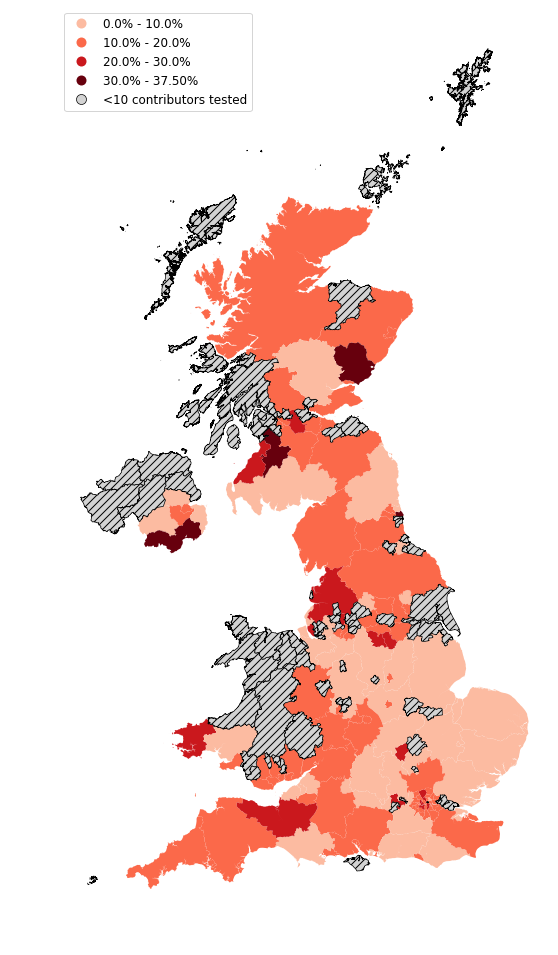

In [140]:
areas.loc[(areas.per_tested_positive>100) | (areas['tested']<=10),'per_tested_positive'] = np.nan

# co-ordinate transformations
target_crs = {'datum':'WGS84', 'no_defs':True, 'proj':'aea', 'lat_1':35, 'lat_2':55, 'lat_0':45, 'lon_0':10}  # UK specific


# plot stuff
fig, ax = plt.subplots(figsize=(10,17))
areas.to_crs(crs=target_crs, inplace=True)
f = areas.plot(ax=ax,
           column='per_tested_positive',
           cmap='Reds',
           vmin=-1,
           #scheme='BoxPlot',
           scheme='UserDefined',
           missing_kwds={
            "color": "lightgrey",
            "edgecolor": "k",
            "linewidth": 0.7,
            "hatch": "///",
            "label": "<10 contributors tested",
           },
           classification_kwds={'bins': [ 10, 20, 30],},
           legend=True,
           legend_kwds={'title_fontsize':13,'fontsize':12, 'loc': 'upper left'})

# pretify
leg = f.get_legend()
labels = ['0.0% - 10.0%','10.0% - 20.0%','20.0% - 30.0%', '30.0% - 37.50%']
for l,t in zip(labels,leg.get_texts()):
    t.set_text(l)
    
ax.axis('off')
fig.show()
plt.savefig('methods_paper/9_tested_pos_'+str(day)+'.png')

/Users/joan-zoe/Envs/ml-lib/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


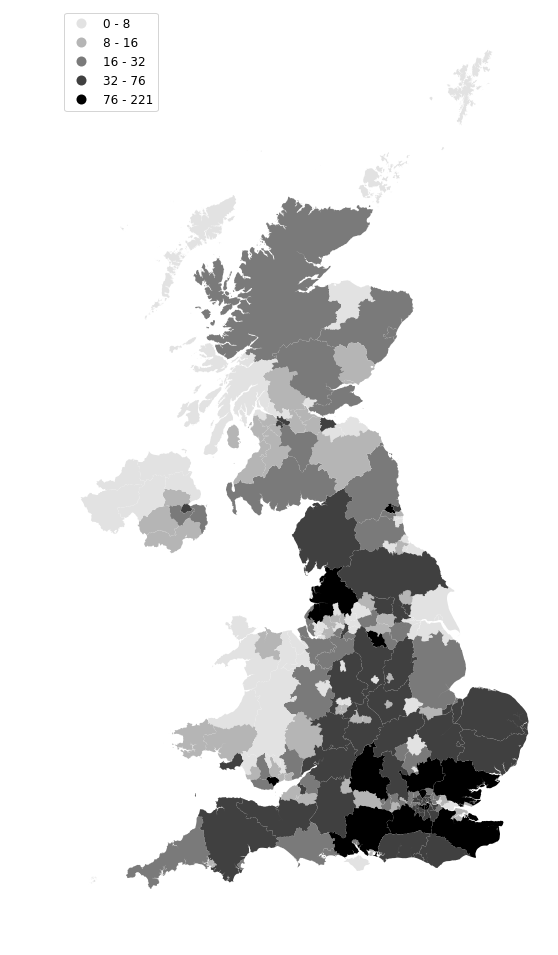

In [143]:
# co-ordinate transformations
target_crs = {'datum':'WGS84', 'no_defs':True, 'proj':'aea', 'lat_1':35, 'lat_2':55, 'lat_0':45, 'lon_0':10}  # UK specific


# plot stuff
fig, ax = plt.subplots(figsize=(10,17))
areas.to_crs(crs=target_crs, inplace=True)
f = areas.plot(ax=ax,
           column='tested',
           cmap='Greys',
           vmin=-1,
           scheme='UserDefined',
           classification_kwds={'bins': [ 8, 16, 32, 76],},
           legend=True,
           legend_kwds={'title_fontsize':13,'fontsize':12, 'loc': 'upper left'})

# pretify
leg = f.get_legend()
labels = ['0 - 8','8 - 16','16 - 32','32 - 76','76 - 221']
for l,t in zip(labels,leg.get_texts()):
    t.set_text(l)
    
ax.axis('off')
fig.show()
plt.savefig('methods_paper/8_tested_'+str(day)+'.png')

/Users/joan-zoe/Envs/ml-lib/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


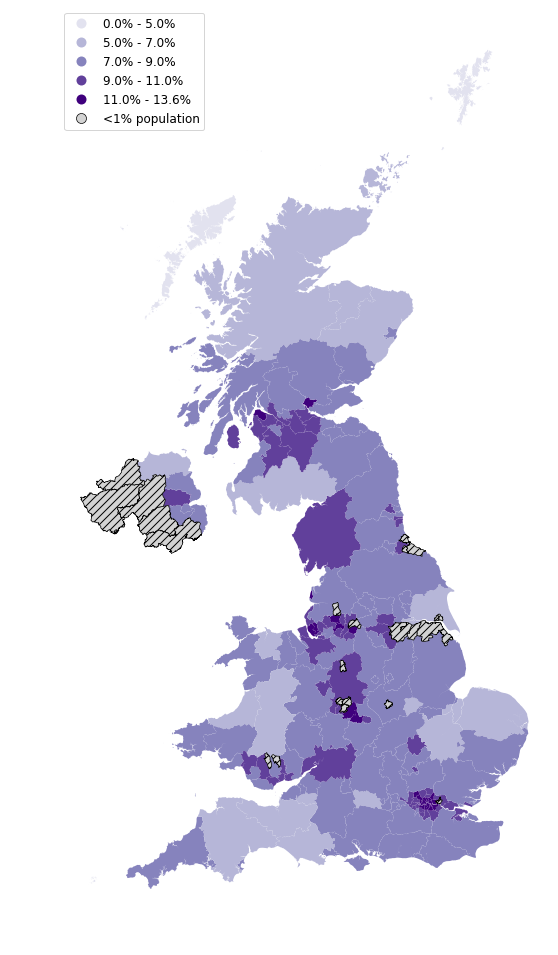

In [187]:
areas.loc[areas['penetration_rate']<1,'per_complex_symptom'] = np.nan

# co-ordinate transformations
target_crs = {'datum':'WGS84', 'no_defs':True, 'proj':'aea', 'lat_1':35, 'lat_2':55, 'lat_0':45, 'lon_0':10}  # UK specific


# plot stuff
fig, ax = plt.subplots(figsize=(10,17))
areas.to_crs(crs=target_crs, inplace=True)
f = areas.plot(ax=ax,
           column='per_complex_symptom',
           cmap='Purples',
           vmin=-1,
           scheme='UserDefined',
           classification_kwds={'bins': [5,7,9,11],},
           legend=True,
           missing_kwds={
            "color": "lightgrey",
            "edgecolor": "k",
            "linewidth": 0.7,
            "hatch": "///",
            "label": "<1% population",
           },
           legend_kwds={'title_fontsize':13,'fontsize':12, 'loc': 'upper left'})

# pretify
leg = f.get_legend()
labels = ['0.0% - 5.0%','5.0% - 7.0%','7.0% - 9.0%','9.0% - 11.0%','11.0% - 13.6%']
for l,t in zip(labels,leg.get_texts()):
    t.set_text(l)
    
ax.axis('off')
fig.show()
plt.savefig('methods_paper/0_complex_symptom_'+str(day)+'.png')

/Users/joan-zoe/Envs/ml-lib/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


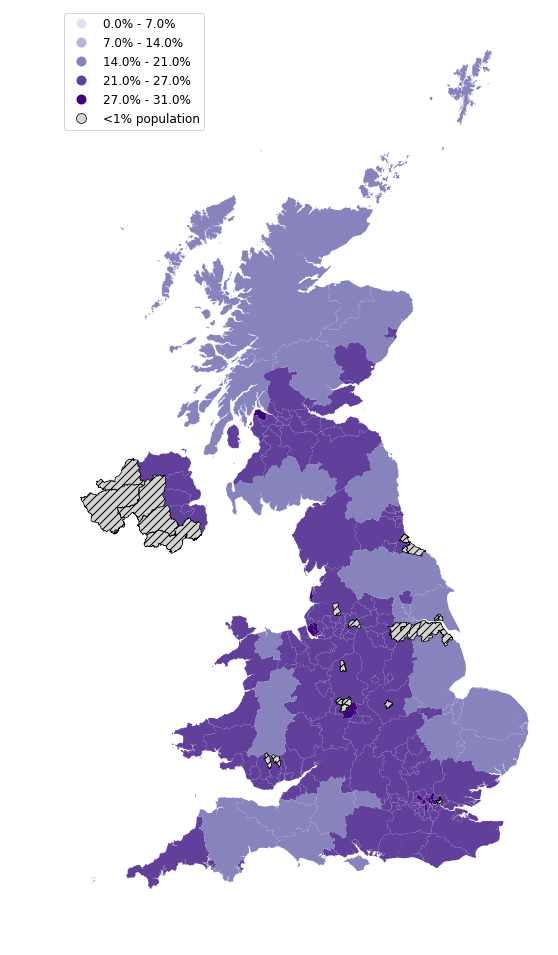

In [189]:
areas.loc[areas['penetration_rate']<1,'per_any_symptom'] = np.nan

# co-ordinate transformations
target_crs = {'datum':'WGS84', 'no_defs':True, 'proj':'aea', 'lat_1':35, 'lat_2':55, 'lat_0':45, 'lon_0':10}  # UK specific


# plot stuff
fig, ax = plt.subplots(figsize=(10,17))
areas.to_crs(crs=target_crs, inplace=True)
f = areas.plot(ax=ax,
           column='per_any_symptom',
           cmap='Purples',
           vmin=-1,
           scheme='UserDefined',
           classification_kwds={'bins': [7,14, 21, 28],},
           legend=True,
           missing_kwds={
            "color": "lightgrey",
            "edgecolor": "k",
            "linewidth": 0.7,
            "hatch": "///",
            "label": "<1% population",
           },
           legend_kwds={'title_fontsize':13,'fontsize':12, 'loc': 'upper left'})

# pretify
leg = f.get_legend()
labels = ['0.0% - 7.0%','7.0% - 14.0%','14.0% - 21.0%','21.0% - 27.0%','27.0% - 31.0%']
for l,t in zip(labels,leg.get_texts()):
    t.set_text(l)
    
ax.axis('off')
fig.show()
plt.savefig('methods_paper/2_any_symptom_'+str(day)+'.png')

/Users/joan-zoe/Envs/ml-lib/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


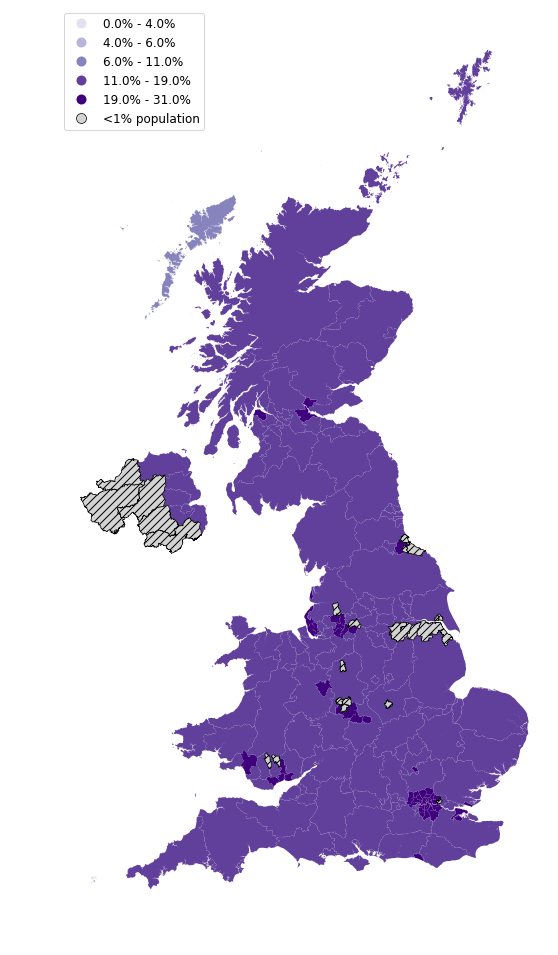

In [157]:
areas.loc[areas['penetration_rate']<1,'per_fatigue'] = np.nan

# co-ordinate transformations
target_crs = {'datum':'WGS84', 'no_defs':True, 'proj':'aea', 'lat_1':35, 'lat_2':55, 'lat_0':45, 'lon_0':10}  # UK specific


# plot stuff
fig, ax = plt.subplots(figsize=(10,17))
areas.to_crs(crs=target_crs, inplace=True)
f = areas.plot(ax=ax,
           column='per_fatigue',
           cmap='Purples',
           vmin=-1,
           scheme='UserDefined',
           classification_kwds={'bins': bins,},
           legend=True,
           missing_kwds={
            "color": "lightgrey",
            "edgecolor": "k",
            "linewidth": 0.7,
            "hatch": "///",
            "label": "<1% population",
           },
           legend_kwds={'title_fontsize':13,'fontsize':12, 'loc': 'upper left'})

# pretify
leg = f.get_legend()
#labels = ['4.8% - 15.0%','15.0% - 17.5%','17.5% - 20.0%','20.0% - 22.5%','22.5% - 25.0%']
for l,t in zip(labels,leg.get_texts()):
    t.set_text(l)
    
ax.axis('off')
fig.show()
plt.savefig('methods_paper/3_fatigue_'+str(day)+'.png')

/Users/joan-zoe/Envs/ml-lib/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


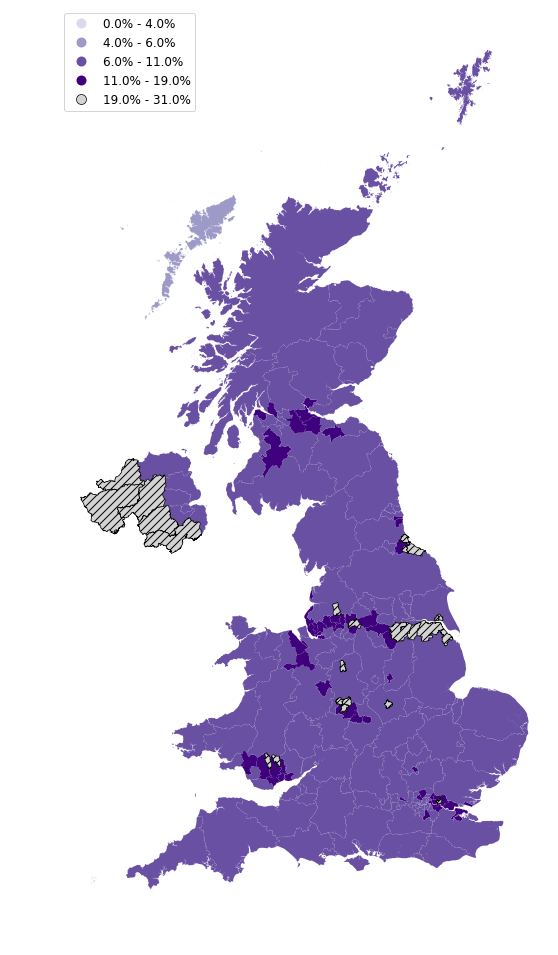

In [158]:
areas.loc[areas['penetration_rate']<1,'per_persistent_cough'] = np.nan

# co-ordinate transformations
target_crs = {'datum':'WGS84', 'no_defs':True, 'proj':'aea', 'lat_1':35, 'lat_2':55, 'lat_0':45, 'lon_0':10}  # UK specific


# plot stuff
fig, ax = plt.subplots(figsize=(10,17))
areas.to_crs(crs=target_crs, inplace=True)
f = areas.plot(ax=ax,
           column='per_persistent_cough',
           cmap='Purples',
           vmin=-1,
           scheme='UserDefined',
           classification_kwds={'bins': bins,},
           legend=True,
           missing_kwds={
            "color": "lightgrey",
            "edgecolor": "k",
            "linewidth": 0.7,
            "hatch": "///",
            "label": "<1% population",
           },
           legend_kwds={'title_fontsize':13,'fontsize':12, 'loc': 'upper left'})

# pretify
leg = f.get_legend()
#labels = ['1.6% - 8.0%','8.0% - 10.0%','10.0% - 12.0%','12.0% - 14.0%','14.0% - 15.1%']
for l,t in zip(labels,leg.get_texts()):
    t.set_text(l)
    
ax.axis('off')
fig.show()
plt.savefig('methods_paper/4_cough_'+str(day)+'.png')

/Users/joan-zoe/Envs/ml-lib/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


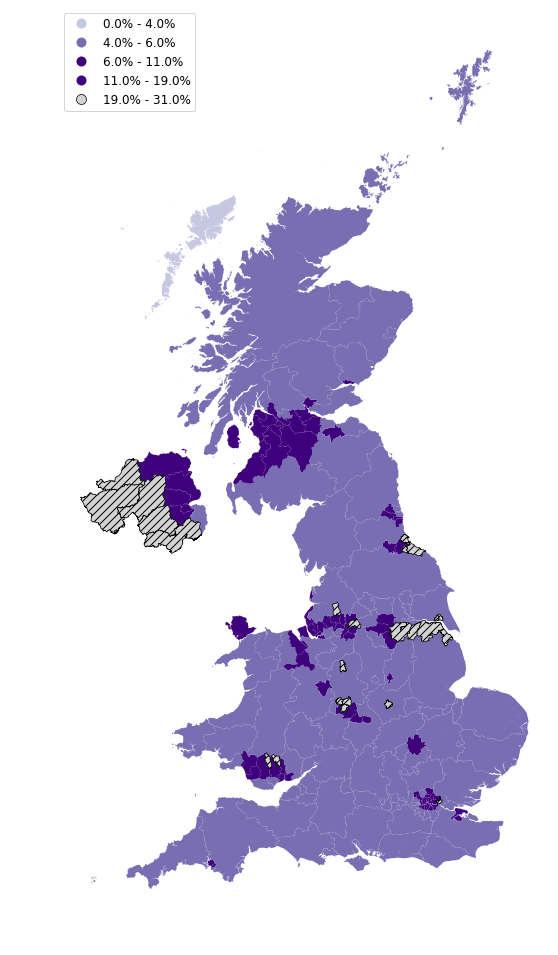

In [159]:
areas.loc[areas['penetration_rate']<1,'per_diarrhoea'] = np.nan

# co-ordinate transformations
target_crs = {'datum':'WGS84', 'no_defs':True, 'proj':'aea', 'lat_1':35, 'lat_2':55, 'lat_0':45, 'lon_0':10}  # UK specific


# plot stuff
fig, ax = plt.subplots(figsize=(10,17))
areas.to_crs(crs=target_crs, inplace=True)
f = areas.plot(ax=ax,
           column='per_diarrhoea',
           cmap='Purples',
           vmin=-1,
           scheme='UserDefined',
           classification_kwds={'bins': bins,},
           legend=True,
           missing_kwds={
            "color": "lightgrey",
            "edgecolor": "k",
            "linewidth": 0.7,
            "hatch": "///",
            "label": "<1% population",
           },
           legend_kwds={'title_fontsize':13,'fontsize':12, 'loc': 'upper left'})

# pretify
leg = f.get_legend()
#labels = ['3.8% - 4.5%','4.5% - 6.0%','6.0% - 7.5%','7.5% - 9.0%','9.0% - 9.5%']
for l,t in zip(labels,leg.get_texts()):
    t.set_text(l)
    
ax.axis('off')
fig.show()
plt.savefig('methods_paper/5_diarrhoea_'+str(day)+'.png')

/Users/joan-zoe/Envs/ml-lib/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


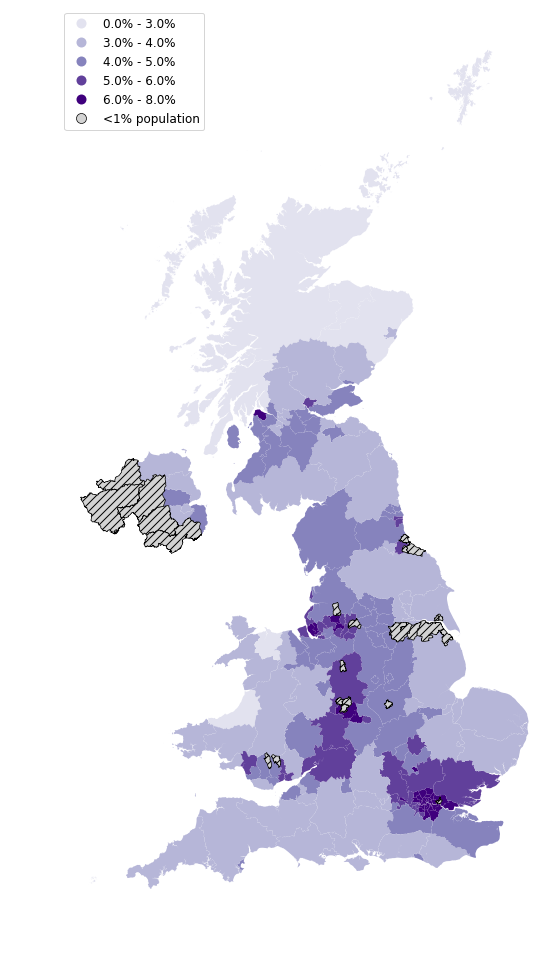

In [190]:
areas.loc[areas['penetration_rate']<1,'per_loss_of_smell'] = np.nan

# co-ordinate transformations
target_crs = {'datum':'WGS84', 'no_defs':True, 'proj':'aea', 'lat_1':35, 'lat_2':55, 'lat_0':45, 'lon_0':10}  # UK specific


# plot stuff
fig, ax = plt.subplots(figsize=(10,17))
areas.to_crs(crs=target_crs, inplace=True)
f = areas.plot(ax=ax,
           column='per_loss_of_smell',
           cmap='Purples',
           vmin=-1,
           scheme='UserDefined',
           classification_kwds={'bins': [3,4,5,6],},
           legend=True,
           missing_kwds={
            "color": "lightgrey",
            "edgecolor": "k",
            "linewidth": 0.7,
            "hatch": "///",
            "label": "<1% population",
           },
           legend_kwds={'title_fontsize':13,'fontsize':12, 'loc': 'upper left'})

# pretify
leg = f.get_legend()
labels = ['0.0% - 3.0%','3.0% - 4.0%','4.0% - 5.0%','5.0% - 6.0%','6.0% - 8.0%']
for l,t in zip(labels,leg.get_texts()):
    t.set_text(l)
    
ax.axis('off')
fig.show()
plt.savefig('methods_paper/6_anosmia_'+str(day)+'.png')

/Users/joan-zoe/Envs/ml-lib/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


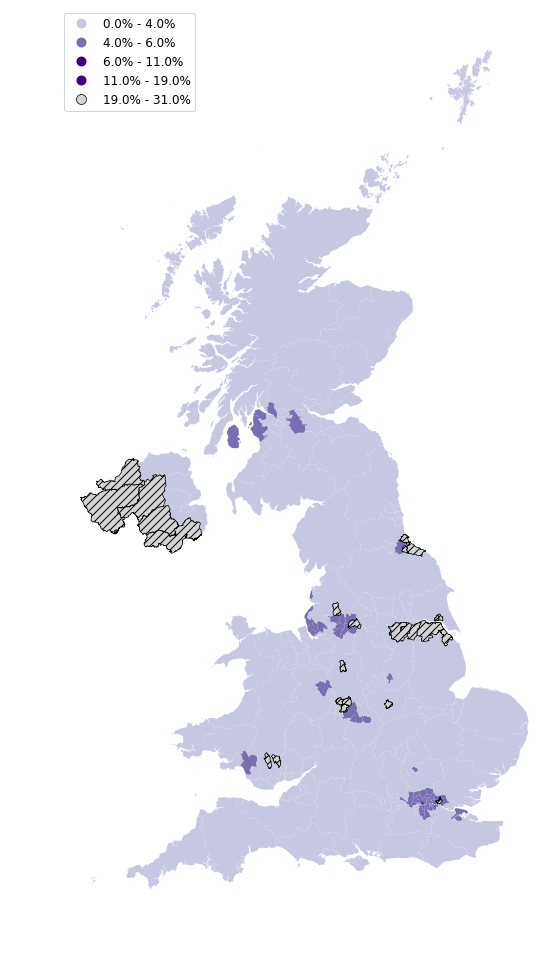

In [161]:
areas.loc[areas['penetration_rate']<1,'per_fever'] = np.nan

# co-ordinate transformations
target_crs = {'datum':'WGS84', 'no_defs':True, 'proj':'aea', 'lat_1':35, 'lat_2':55, 'lat_0':45, 'lon_0':10}  # UK specific


# plot stuff
fig, ax = plt.subplots(figsize=(10,17))
areas.to_crs(crs=target_crs, inplace=True)
f = areas.plot(ax=ax,
           column='per_fever',
           cmap='Purples',
           vmin=-1,
           scheme='UserDefined',
           classification_kwds={'bins': bins,},
           legend=True,
           missing_kwds={
            "color": "lightgrey",
            "edgecolor": "k",
            "linewidth": 0.7,
            "hatch": "///",
            "label": "<1% population",
           },
           legend_kwds={'title_fontsize':13,'fontsize':12, 'loc': 'upper left'})

# pretify
leg = f.get_legend()
#labels = ['0.0% - 2.0%','2.0% - 3.0%','3.0% - 4.0%','4.0% - 5.0%','5.0% - 6.5%']
for l,t in zip(labels,leg.get_texts()):
    t.set_text(l)
    
ax.axis('off')
fig.show()
plt.savefig('methods_paper/7_fever_'+str(day)+'.png')